<a href="https://colab.research.google.com/github/oneonethree113/Advanced-Python-Learning/blob/main/Attention_Model_Predict_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
# Replace 'filename.csv' with the path of your CSV file
csv_file = 'data.csv'

# Read the CSV file using pandas
data = pd.read_csv(csv_file)
data = data.drop('Date', axis=1)
shiftDay=-60
sequence_length = 200

# Display the first 5 rows of the data
print(data.head())

         Asset      Signal1     Signal2     Signal3     Signal4     Signal5  \
0  4258.481700  4237.827494  393.780879 -337.933192  659.763906 -752.865453   
1  4260.246443  4222.822224  378.585650 -364.449284  648.940384 -732.505856   
2  4262.254628  4213.824762  389.955615 -391.594831  641.329710 -728.611976   
3  4289.405332  4239.016108  406.660516 -333.249594  683.822313 -729.657222   
4  4293.746629  4232.818801  403.366787 -320.479903  682.553985 -713.180569   

       Signal6     Signal7     Signal8  
0  1034.127659 -950.257818  198.264577  
1  1042.256957 -977.358249  211.206055  
2  1063.217724 -951.518386  198.595598  
3  1079.316062 -932.785850  181.822031  
4  1087.226725 -941.674136  197.875560  


In [17]:
# Assuming your columns are named 'column1' and 'column2'
# Replace these names with the actual column names in your CSV file
column1 = data['Asset']
shifted_column1 = column1.shift(shiftDay)

# Calculate the new column values
new_column_values = shifted_column1/ column1 

# Add the new column to the DataFrame
data['5daysChange'] = new_column_values

# Display the first 10 rows of the updated DataFrame
print(data.head(10))

         Asset      Signal1     Signal2     Signal3     Signal4     Signal5  \
0  4258.481700  4237.827494  393.780879 -337.933192  659.763906 -752.865453   
1  4260.246443  4222.822224  378.585650 -364.449284  648.940384 -732.505856   
2  4262.254628  4213.824762  389.955615 -391.594831  641.329710 -728.611976   
3  4289.405332  4239.016108  406.660516 -333.249594  683.822313 -729.657222   
4  4293.746629  4232.818801  403.366787 -320.479903  682.553985 -713.180569   
5  4311.970686  4228.845149  413.749839 -288.097316  681.237390 -722.553177   
6  4326.173719  4199.608920  394.909468 -293.436046  685.068351 -707.972621   
7  4358.074625  4215.387698  398.256016 -288.451123  699.542201 -698.375011   
8  4356.275711  4245.368791  427.906417 -264.539216  696.706451 -691.152081   
9  4336.095967  4253.875513  433.229688 -280.090382  699.424044 -701.750340   

       Signal6     Signal7     Signal8  5daysChange  
0  1034.127659 -950.257818  198.264577     0.943746  
1  1042.256957 -977.35

2. Preprocess the data: Prepare the input and output sequences for your model using a sliding window approach. You'll create sequences of 10 rows as input, and the corresponding new column value as output.


In [18]:
def create_sequences(input_data, target_data, seq_length):
    inputs = []
    targets = []
    for i in range(len(input_data) - seq_length):
        inputs.append(input_data[i:i+seq_length])
        targets.append(target_data[i+seq_length])
    return np.array(inputs), np.array(targets)

# Assuming your DataFrame is named `data`
# Separate the input features and target values
input_features = data.drop(columns=['5daysChange']).to_numpy()
target_values = data['5daysChange'].to_numpy()

# Discard the last 5 elements in both input_features and target_values
input_features = input_features[:shiftDay]
target_values = target_values[:shiftDay]

inputs, targets = create_sequences(input_features, target_values, sequence_length)

In [19]:
data.head(10)

,Asset,Signal1,Signal2,Signal3,Signal4,Signal5,Signal6,Signal7,Signal8,5daysChange
0,4258.481700,4237.827494,393.780879,-337.933192,659.763906,-752.865453,1034.127659,-950.257818,198.264577,0.943746
1,4260.246443,4222.822224,378.585650,-364.449284,648.940384,-732.505856,1042.256957,-977.358249,211.206055,0.935473
2,4262.254628,4213.824762,389.955615,-391.594831,641.329710,-728.611976,1063.217724,-951.518386,198.595598,0.944930
3,4289.405332,4239.016108,406.660516,-333.249594,683.822313,-729.657222,1079.316062,-932.785850,181.822031,0.940369
4,4293.746629,4232.818801,403.366787,-320.479903,682.553985,-713.180569,1087.226725,-941.674136,197.875560,0.938805
5,4311.970686,4228.845149,413.749839,-288.097316,681.237390,-722.553177,1097.412119,-943.391467,212.152788,0.929414
6,4326.173719,4199.608920,394.909468,-293.436046,685.068351,-707.972621,1081.896516,-946.380044,205.272782,0.920568
7,4358.074625,4215.387698,398.256016,-288.451123,699.542201,-698.375011,1072.855393,-986.138310,211.834670,0.919539
8,4356.275711,4245.368791,427.906417,-264.539216,696.706451,-691.152081,1083.184939,-968.847091,228.131274,0.921081
9,4336.095967,4253.875513,433.229688,-280.090382,699.424044,-701.750340,1099.384857,-958.402051,214.266060,0.921623


In [20]:
inputs.shape

(4740, 200, 9)


3. Split the data into training and testing sets.

In [21]:
split_index = int(0.75 * len(inputs))

# Split the data into training and testing sets
X_train, X_test = inputs[:split_index], inputs[split_index:]
y_train, y_test = targets[:split_index], targets[split_index:]



4. Implement the attention model using PyTorch.




In [24]:

import torch
import torch.nn as nn

class AttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, num_layers, output_size):
        super(AttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Three Multi-Head Attention layers
        self.multi_head_attention1 = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads)
        self.multi_head_attention2 = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads)
        self.multi_head_attention3 = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads)
        
        fc_hidden_size = int(2/3 * hidden_size)
        self.fc1 = nn.Linear(hidden_size, fc_hidden_size)
        self.fc2 = nn.Linear(fc_hidden_size, int(2/3 *fc_hidden_size))
        self.fc3 = nn.Linear(int(2/3 *fc_hidden_size), output_size)
    def forward(self, x):
        x = x[:, ::5, :]
        # LSTM
        lstm_out, _ = self.lstm(x)
        
        # Multi-Head Attention layers
        attention_out1, _ = self.multi_head_attention1(lstm_out, lstm_out, lstm_out)
        attention_out2, _ = self.multi_head_attention2(attention_out1, attention_out1, attention_out1)
        attention_out3, _ = self.multi_head_attention3(attention_out2, attention_out2, attention_out2)
        
        # Fully connected layer        # Fully connected layers
        fc_out = nn.ReLU()(self.fc1(attention_out3[:, -1, :]))
        fc_out = nn.ReLU()(self.fc2(fc_out))
        out = self.fc3(fc_out)
        return out

# Set the input size, hidden size, number of heads, number of layers, and output size
input_size = inputs.shape[2]  # Number of features in your data
hidden_size = 64
num_heads = 16
num_layers = 2
output_size = 1

# Create the model
model = AttentionModel(input_size, hidden_size, num_heads, num_layers, output_size)



5. Train the model using the training data.



In [31]:
def test_loss(model, criterion, test_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            running_loss += loss.item()
    return running_loss / len(test_loader)

# Set hyperparameters
learning_rate = 0.001
num_epochs = 100
batch_size = 32

# Create data loaders
train_data = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = torch.utils.data.TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

# Set the loss function and optimizer
criterion = nn.MSELoss()
from torch.optim.lr_scheduler import StepLR
# Set the scheduler parameters

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

step_size = 10  # Decrease learning rate every 10 epochs
gamma = 0.3     # Multiply the learning rate by 0.1 (reduce it to 10%)

# Create the scheduler
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
# Initialize lists to store losses
training_losses = []
testing_losses = []

# Train the model and record losses
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()   

    train_loss = running_loss / len(train_loader)
    training_losses.append(train_loss)
    
    test_loss_value = test_loss(model, criterion, test_loader)
    testing_losses.append(test_loss_value)
    # Update the learning rate     
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss_value:.4f}')

Epoch [1/100], Train Loss: 0.0021, Test Loss: 0.0015
Epoch [2/100], Train Loss: 0.0019, Test Loss: 0.0015
Epoch [3/100], Train Loss: 0.0018, Test Loss: 0.0015
Epoch [4/100], Train Loss: 0.0020, Test Loss: 0.0014
Epoch [5/100], Train Loss: 0.0019, Test Loss: 0.0014
Epoch [6/100], Train Loss: 0.0019, Test Loss: 0.0014
Epoch [7/100], Train Loss: 0.0019, Test Loss: 0.0020
Epoch [8/100], Train Loss: 0.0019, Test Loss: 0.0016
Epoch [9/100], Train Loss: 0.0019, Test Loss: 0.0034
Epoch [10/100], Train Loss: 0.0021, Test Loss: 0.0014
Epoch [11/100], Train Loss: 0.0019, Test Loss: 0.0014
Epoch [12/100], Train Loss: 0.0018, Test Loss: 0.0014
Epoch [13/100], Train Loss: 0.0019, Test Loss: 0.0016
Epoch [14/100], Train Loss: 0.0018, Test Loss: 0.0014
Epoch [15/100], Train Loss: 0.0018, Test Loss: 0.0014
Epoch [16/100], Train Loss: 0.0019, Test Loss: 0.0014
Epoch [17/100], Train Loss: 0.0019, Test Loss: 0.0014
Epoch [18/100], Train Loss: 0.0018, Test Loss: 0.0017
Epoch [19/100], Train Loss: 0.0020, T

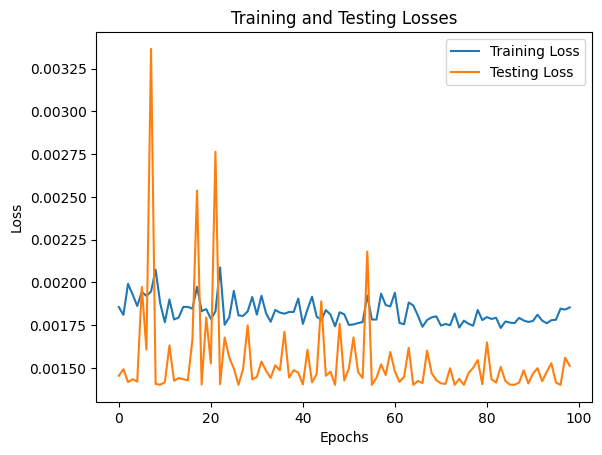

In [32]:
import matplotlib.pyplot as plt


def plot_losses(training_losses, testing_losses):
    plt.figure()
    plt.plot(training_losses[1:], label='Training Loss')
    plt.plot(testing_losses[1:], label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Losses')
    plt.legend()
    plt.show()

# Plot the training and testing losses
plot_losses(training_losses, testing_losses)


6. Evaluate the model using the testing data.

In [33]:

# Create a test data loader
test_data = torch.utils.data.TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

# Evaluate the model
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        output = model(batch_X)
        predictions.append(output.item())
        actuals.append(batch_y.item())

# Calculate metrics such as Mean Squared Error (MSE) or Mean Absolute Error (MAE)
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')


Mean Squared Error: 0.0016
Mean Absolute Error: 0.0333


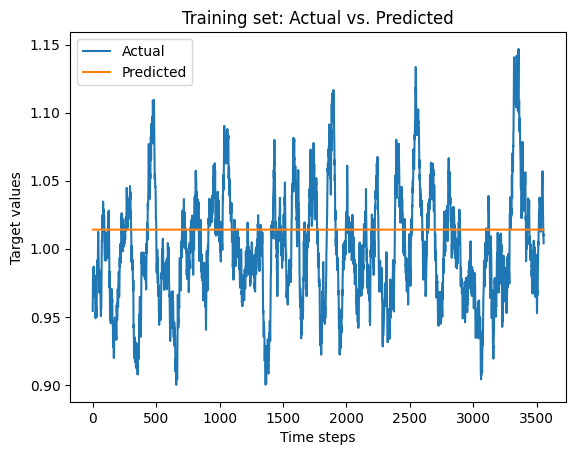

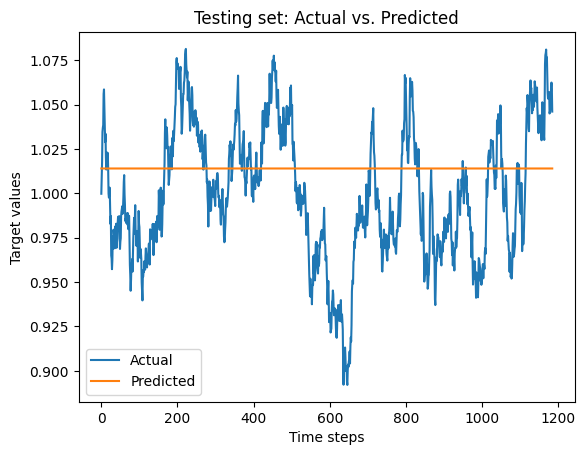

In [34]:
import matplotlib.pyplot as plt

def plot_predictions(actuals, predictions, title):
    plt.figure()
    plt.plot(actuals, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.xlabel('Time steps')
    plt.ylabel('Target values')
    plt.title(title)
    plt.legend()
    plt.show()

# Evaluate the model and create graphs for the training set
model.eval()
train_predictions = []
train_actuals = []
with torch.no_grad():
    for batch_X, batch_y in torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False):
        output = model(batch_X)
        train_predictions.append(output.item())
        train_actuals.append(batch_y.item())
plot_predictions(train_actuals, train_predictions, 'Training set: Actual vs. Predicted')

# Evaluate the model and create graphs for the testing set
test_predictions = []
test_actuals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        output = model(batch_X)                                                                                                                                                       
        test_predictions.append(output.item())
        test_actuals.append(batch_y.item())
plot_predictions(test_actuals, test_predictions, 'Testing set: Actual vs. Predicted')